# Análisis en agricultura:
## Autor: Caleb Ventura

In [1]:
#librerías necesarias

from __future__ import division, print_function, unicode_literals
from numpy import *
import numpy as np
import matplotlib.pyplot as mplot
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import seaborn as sns #Need to install
import scipy.stats as stats
import pylab
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
from sklearn.cluster import KMeans as km
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso as LS
from sklearn.linear_model import Ridge as RG
from sklearn.tree import DecisionTreeRegressor as scart
from sklearn.manifold import TSNE
%matplotlib inline

# Lectura y limpieza de datos
#### 1. Leyendo el archivo principal de datos agrícolas :
- Base de datos principal que tiene información sobre el área de cultivo y la producción de cada estado desde 1997..

In [2]:
# Leer csv: contiene datos principales
#crop_prod: variable
crop_prod=pd.read_csv('apy.csv',delimiter=',')

# fillna reemplaza los NaN por ceros (0)
crop_prod=crop_prod.fillna(0)
#crop_prod.head(6)
#imprime los tipos de datos que contiene apy.csv
#print(crop_prod.dtypes)

In [3]:
#Ordenamiento segun columna 0
crop_prod.sort_values(by=crop_prod.columns[0])

#fila 0 al 6, 3ra columna

#states (Estados) es la lista ordenada de la columna 0
#Este algoritmo permite enlistar de forma ordenada con "sorted" los estados, elimina los repetidos con "set"
states = sorted(set(crop_prod.iloc[:,2].values))
#states
# states --> Imprime la lista de estados sin repetir
#ver los primeros 5 filas (por defecto)
#crop_prod.head(10)

In [4]:
crop_prod.head()
# imprime los 5 primeros por defecto

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


#### 2. Lectura de la base de datos con el precio mayorista de los cultivos a lo largo de los años.
- Los productos básicos son cultivos
- Los precios están en Rupias / Quintal

In [5]:
#Lectura del cvs "Crops_price"
crop_price=pd.read_csv("Crops_price.csv",delimiter=',')

#Recorre cada columna
for i in range(1,crop_price.shape[1]):
    
    # Convierte todo en números
    # convierte los errores en NaN
    crop_price.iloc[:,i]=pd.to_numeric(crop_price.iloc[:,i],errors='coerce')
    
    #Rellena los NaN y los convierte en cero
    crop_price.iloc[:,i]=crop_price.iloc[:,i].fillna(0)

# Renombrar el título de la columna "commoditties"
crop_price = crop_price.rename(columns = {'Commodities(rs/quin)':'Commodities'})

#muestra los 5 primeros por defecto
crop_price.head()

,Commodities,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Paddy (Common),550.0,560.0,570.0,580.0,645.0,850.0,950.0,1000.0,1080,1250.0
1,Paddy (Grade ‘A’),580.0,590.0,600.0,610.0,675.0,880.0,980.0,1030.0,1110,1280.0
2,Wheat,630.0,640.0,650.0,750.0,1000.0,1080.0,1100.0,1120.0,1285,1350.0
3,Jowar (Hybrid),490.0,515.0,525.0,540.0,600.0,840.0,840.0,880.0,980,1500.0
4,Jowar (Maldandi),0.0,0.0,0.0,555.0,620.0,860.0,860.0,900.0,1000,1520.0


#### 3. Incluida la base de datos para el área de cultivo de los principales cultivos

In [6]:
# Lectura de la tabla "area_cult" Área de cultivo para los principales productos
area_cult=pd.read_csv("area_cult.csv",delimiter=',')
#print(sum(area_cult.isna()))
area_cult.head()

,Year,Rice,Jowar,Bajra,Maize,Ragi,Small millets,Wheat,Barley,Gram,...,Rubber,Banana,Sugarcane,Tobacco,Potato,Black pepper,Dry chillies,Ginger,Coconut,Turmeric
0,2000,44712,9856,9829,6611,1759,1424,25731,778,5185,...,400,459,4316,262,1222,214,836,86,1824,192
1,2001,44904,9795,9529,6582,1647,1310,26345,660,6416,...,401,489,4412,348,1208,219,880,91,1932,167
2,2002,41176,9300,7740,6635,1415,1201,25196,702,5906,...,408,460,4520,327,1345,224,827,88,1922,150
3,2003,42593,9331,10612,7343,1666,1191,26595,657,7048,...,428,391,3938,370,1289,233,774,85,1934,150
4,2004,41907,9092,8233,7430,1553,1101,26383,616,6715,...,440,404,3662,366,1318,228,738,95,1935,159


#### 4. Lectura de la base de datos para conocer el costo del cultivo de cultivos en ese estado
- La información se divide en tres partes:
- A2 (costo real pagado), A2 + FL (costo real pagado más valor imputado del trabajo familiar)
- C2 (costo integral que incluye la renta imputada y los intereses sobre la tierra y el capital en propiedad). Como es evidente, C2> A2 + FL> A2.
- Costo de producción por quintal.

In [7]:
culti_cost=pd.read_csv("culti_cost.csv",delimiter=',')
culti_cost=culti_cost.fillna(0)
# print(sum(culti_cost.isna()))
state_cult = sorted(set(culti_cost.iloc[:,1]))
print(culti_cost.shape)
culti_cost.head()

(50, 20)


,Crop,State/ UT Name,Cost of Cultivation (`/Hectare) - A2+FL - 2008-09,Cost of Cultivation (`/Hectare) - A2+FL - 2009-10,Cost of Cultivation (`/Hectare) - A2+FL - 2010-11,Cost of Cultivation (`/Hectare) - A2+FL - 2011-12,Cost of Cultivation (`/Hectare) - A2+FL - 2012-13,Cost of Cultivation (`/Hectare) - A2+FL - 2013-14,Cost of Cultivation(`/Hectare) - C2 - 2008-09,Cost of Cultivation(`/Hectare) - C2 - 2009-10,Cost of Cultivation(`/Hectare) - C2 - 2010-11,Cost of Cultivation(`/Hectare) - C2 - 2011-12,Cost of Cultivation (`/Hectare) - C2 - 2012-13,Cost of Cultivation (`/Hectare) - C2 - 2013-14,Cost of Production (`/Quintal) - C2 - 2008-09,Cost of Production (`/Quintal) - C2 - 2009-10,Cost of Production (`/Quintal) - C2 - 2010-11,Cost of Production (`/Quintal) - C2 - 2011-12,Cost of Production (`/Quintal) - C2 - 2012-13,Cost of Production (`/Quintal) - C2 - 2013-14
0,Paddy,Andhra Pradesh,29664.84,35104.80,35090.78,37946.69,42669.85,46781.05,46450.20,54202.54,51505.34,58027.19,68149.69,72417.05,789.90,932.50,916.98,976.36,1135.01,1248.20
1,Paddy,Odisha,17478.05,19175.75,21894.98,27243.15,31723.25,35569.85,25909.05,28143.88,30318.40,35972.50,44091.78,46839.15,715.04,793.65,955.59,1221.44,1159.54,1408.40
2,Paddy,Punjab,25154.75,29031.73,30793.25,31248.72,37103.96,39686.81,45291.24,50650.21,51279.34,53813.93,64811.36,68382.86,669.86,773.18,836.46,904.30,945.73,1043.27
3,Paddy,Uttar Pradesh,17022.00,21336.61,21281.30,28147.45,29436.98,30982.85,28144.50,32327.78,32299.35,40146.68,43620.87,45617.43,732.62,812.97,806.87,957.83,1019.43,1031.23
4,Paddy,West Bengal,24731.06,28101.85,32872.72,37959.78,42770.22,45783.94,33046.12,38111.55,43019.85,49142.99,55982.79,60924.19,731.25,865.12,1022.83,1085.76,1236.05,1366.80


## Visualización de bases de datos:
#### Datos de precios de cultivos

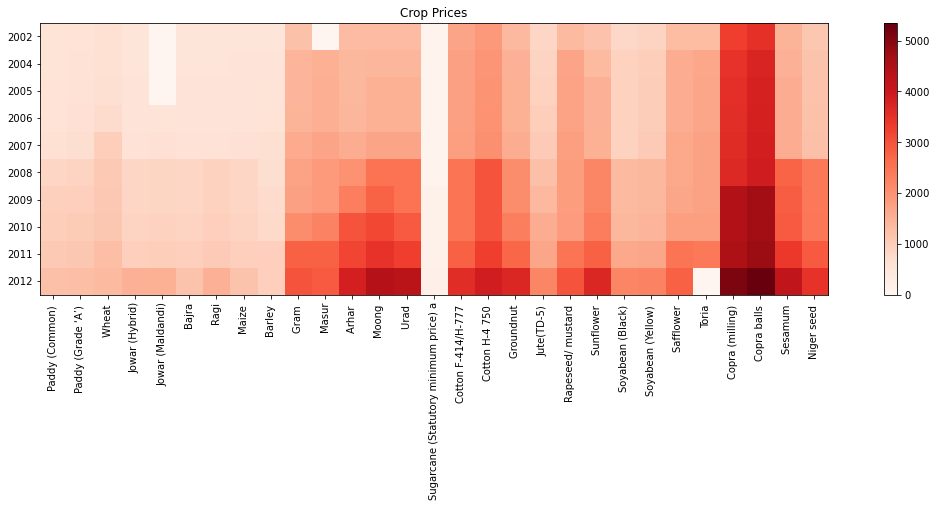

In [8]:
mat1 = np.matrix(crop_price.values[:,1:],dtype='float')
fig = plt.figure(num=2,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
plt.imshow(mat1.T, cmap='Reds')
ax.set_yticks(np.arange(len(crop_price.columns[1:])))
ax.set_xticks(np.arange(len(crop_price.iloc[:,0])))
ax.set_yticklabels(crop_price.columns[1:])
ax.set_xticklabels(crop_price.iloc[:,0],rotation='vertical')
plt.colorbar()
plt.title('Crop Prices')
plt.show()

#### Área bajo datos de cultivo

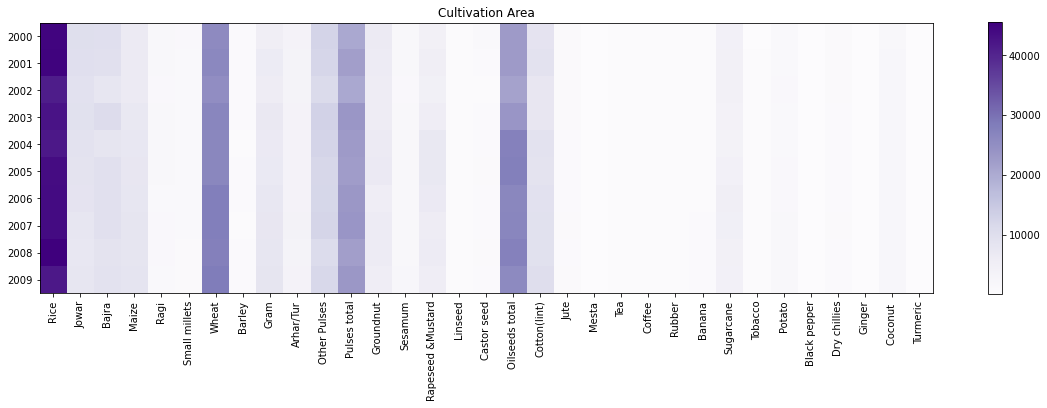

In [9]:
mat2 = np.matrix(area_cult.values[:,1:],dtype='float')
# print(mat2.shape)
mat2=np.delete(mat2,12,1)
# print(mat2.shape)
fig = plt.figure(num=3,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_xticks(np.arange(len(np.delete(area_cult.columns[1:],12))))
ax.set_yticks(np.arange(len(area_cult.iloc[:,0])))
ax.set_xticklabels(np.delete(area_cult.columns[1:],12),rotation='vertical')
ax.set_yticklabels(area_cult.iloc[:,0])
plt.imshow(mat2, cmap='Purples')
plt.colorbar()
plt.title('Cultivation Area')
plt.show()

#### Costo de cultivo de los principales cultivos (A2 + FL y c2):

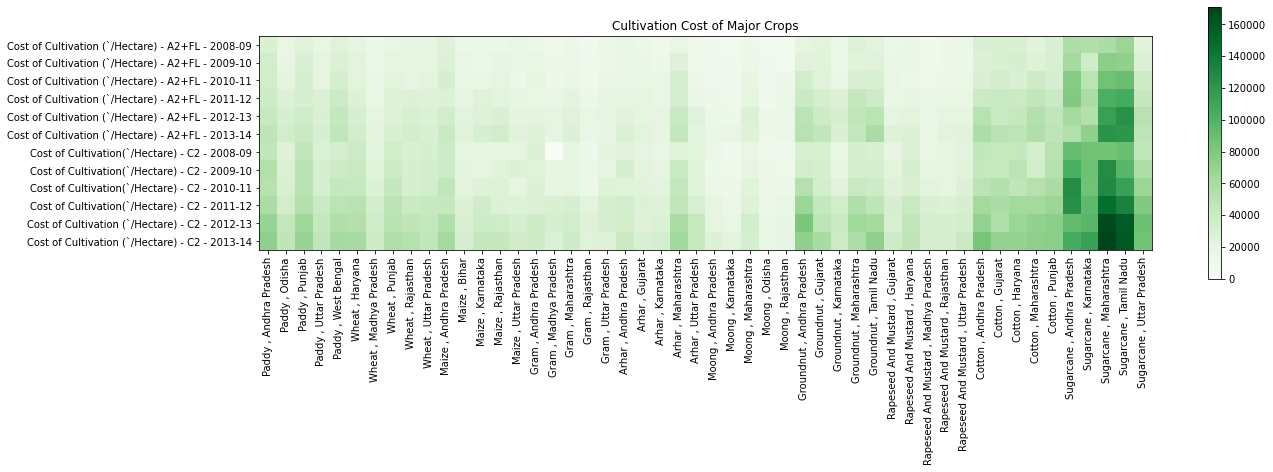

In [10]:
mat3 = np.matrix(culti_cost.values[:,2:14],dtype='float').T
fig = plt.figure(num=3,figsize=(20,5))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_yticks(np.arange(len(culti_cost.columns[2:14])))
ax.set_xticks(np.arange(len(culti_cost.values[:,0]+' , '+culti_cost.values[:,1])))
ax.set_yticklabels(culti_cost.columns[2:14])
ax.set_xticklabels(culti_cost.values[:,0]+' , '+culti_cost.values[:,1],rotation='vertical')
plt.imshow(mat3, cmap='Greens')
plt.colorbar()
plt.title('Cultivation Cost of Major Crops')
plt.show()

#### Costo de cultivo de los principales cultivos por quintal en ese estado:

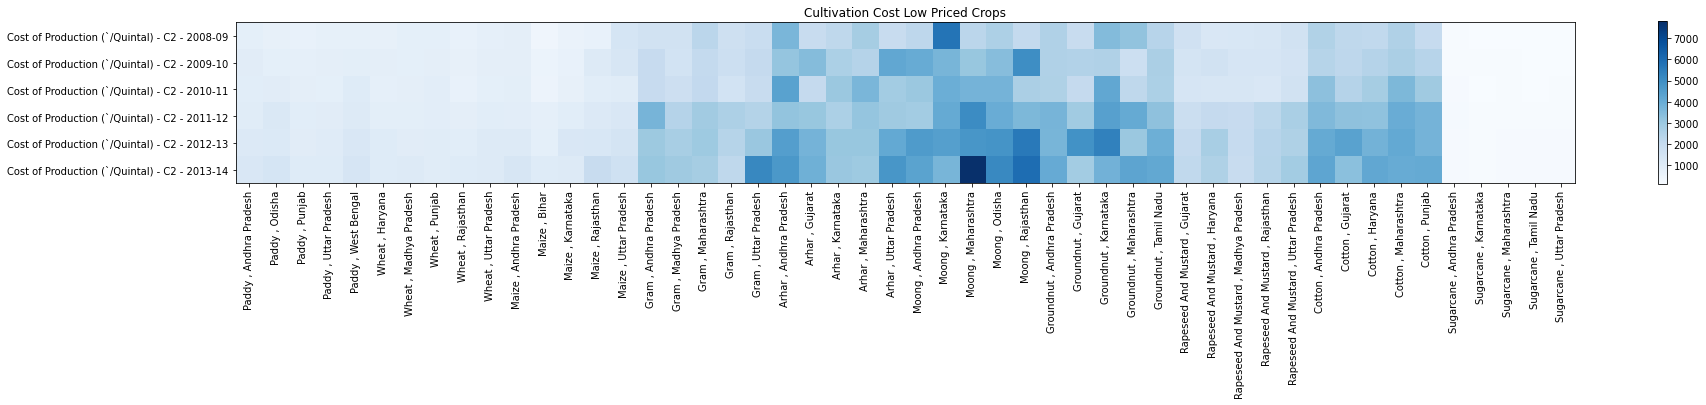

In [11]:
mat4 = np.matrix(culti_cost.values[:,14:],dtype='float').T
fig = plt.figure(num=4,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
# ax.set_aspect('equal')
ax.set_yticks(np.arange(len(culti_cost.columns[14:])))
ax.set_xticks(np.arange(len(culti_cost.values[:,0]+' , '+culti_cost.values[:,1])))
ax.set_yticklabels(culti_cost.columns[14:])
ax.set_xticklabels(culti_cost.values[:,0]+' , '+culti_cost.values[:,1],rotation='vertical')
plt.imshow(mat4, cmap='Blues')
plt.colorbar()
plt.title('Cultivation Cost Low Priced Crops')
plt.show()

#### 5. Lectura de las temperaturas medias a lo largo de los años de la base de datos

In [12]:
temperature = pd.read_csv('Mean_Temperatures.csv',delimiter=',')
temperature.head()

,YEAR,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,2000,24.60,19.33,26.47,27.23,22.68
1,2001,24.73,19.75,26.82,27.47,22.52
2,2002,25.00,19.65,27.22,27.71,22.58
3,2003,24.72,19.82,26.52,27.64,22.23
4,2004,24.74,19.93,27.06,27.33,22.24


#### Visualización de datos de temperatura media a lo largo de los años

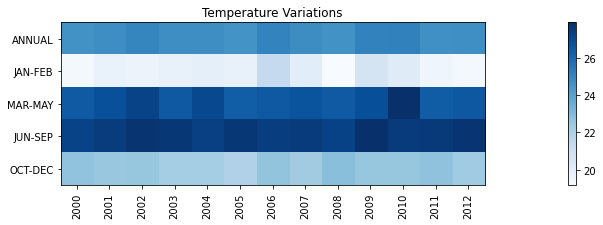

In [13]:
mat5 = np.matrix(temperature.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(temperature.columns[1:])))
ax.set_xticks(np.arange(len(temperature.values[:,0])))
ax.set_yticklabels(temperature.columns[1:])
ax.set_xticklabels(temperature.values[:,0].astype(int),rotation='vertical')
plt.imshow(mat5, cmap='Blues')
plt.colorbar()
plt.title('Temperature Variations')
plt.show()

#### 6. Leer los datos de las precipitaciones anuales en diferentes estados

In [14]:
rainfall =  pd.read_csv('rainfall_cleaned.csv',delimiter=',')
rainfall.head()

,STATES,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL
0,ANDAMAN & NICOBAR ISLANDS,2000,53.0,59.0,171.3,218.1,422.8,357.0,176.3,460.8,250.1,321.2,158.3,115.2,2763.2
1,ANDAMAN & NICOBAR ISLANDS,2001,89.0,15.7,143.3,30.1,705.3,370.7,341.3,469.0,334.4,267.6,222.6,91.8,3080.9
2,ANDAMAN & NICOBAR ISLANDS,2002,10.6,0.0,11.5,100.2,366.7,358.3,317.4,429.8,420.0,169.0,306.7,129.9,2620.2
3,ANDAMAN & NICOBAR ISLANDS,2003,44.3,7.9,149.2,19.4,296.3,159.9,494.9,379.4,371.9,310.4,74.1,48.0,2355.9
4,ANDAMAN & NICOBAR ISLANDS,2004,54.5,35.9,36.5,41.6,505.1,423.9,378.9,308.7,280.7,223.9,169.9,0.4,2460.1


#### Modificación de datos para observación

In [15]:
rainfall1=rainfall.copy()
rainfall1 = rainfall1.groupby(['STATES','YEAR'],as_index=True).mean()
# rainfall1.iloc[:,12].unstack(level=-1).reset_index().head()

#### Visualización de datos de lluvia anual a lo largo de los años

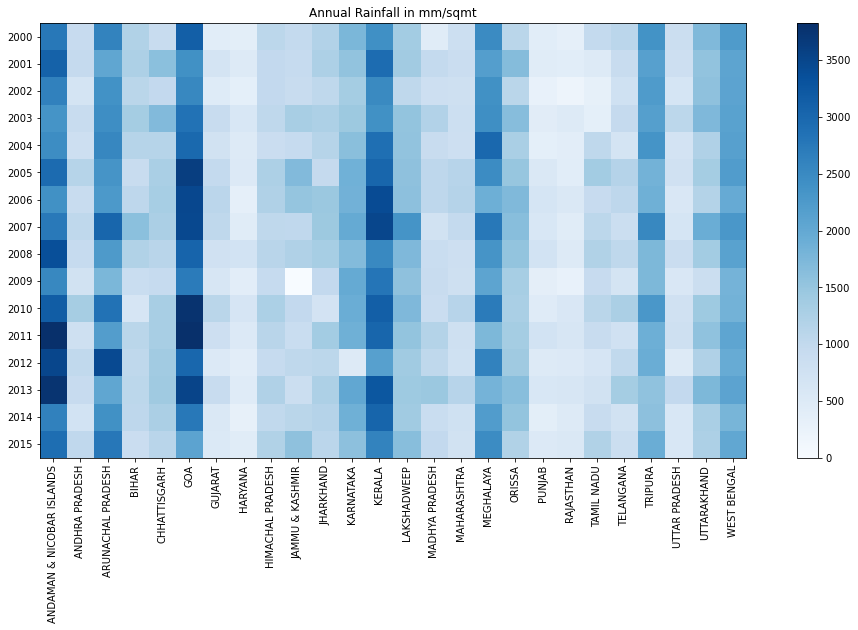

In [16]:
mat6 = np.matrix(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,1:],dtype='float').T
fig = plt.figure(num=6,figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(rainfall1.iloc[:,12].unstack(level=-1).reset_index().columns[1:])))
ax.set_xticks(np.arange(len(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,0])))
ax.set_yticklabels(rainfall1.iloc[:,12].unstack(level=-1).reset_index().columns[1:])
ax.set_xticklabels(rainfall1.iloc[:,12].unstack(level=-1).reset_index().values[:,0],rotation='vertical')
plt.imshow(mat6, cmap='Blues')
plt.colorbar()
plt.title('Annual Rainfall in mm/sqmt')
plt.show()

#### 7. Lectura de datos para la tasa de crecimiento de los principales cultivos a lo largo de los años

In [17]:
growth = pd.read_csv('Avg annual Growth Rate_Major Crops.csv',delimiter = ',')
growth = pd.concat([growth.iloc[:,0],growth.iloc[:,5:]],axis=1,sort=False)
growth = growth.dropna()
growth.head()

,Crop,(Ninth Plan) 1997-98 to 2001-02,(Tenth Plan) 2002-03 to 2006-07,(Eleventh Plan) 2007-08 to 2011-12
0,Wheat,0.7,-0.3,3.0
1,Rice,2.1,1.2,2.2
2,Jowar,0.2,2.1,3.1
3,Bajra,4.9,7.3,8.4
4,Maize,3.1,-0.2,6.5


#### Visualización de datos de tasa de crecimiento

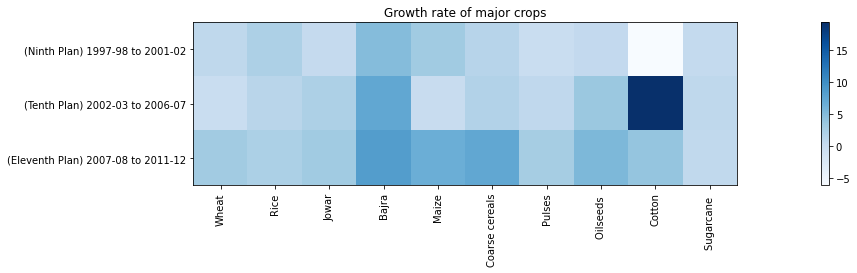

In [18]:
mat7 = np.matrix(growth.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(growth.columns[1:])))
ax.set_xticks(np.arange(len(growth.values[:,0])))
ax.set_yticklabels(growth.columns[1:])
ax.set_xticklabels(growth.values[:,0],rotation='vertical')
plt.imshow(mat7, cmap='Blues')
plt.colorbar()
plt.title('Growth rate of major crops')
plt.show()

#### 8. Lectura de la base de datos del número de suicidios en varios estados a lo largo de los años.

In [19]:
suicides = pd.read_csv('suicides_10-14.csv',delimiter = ',')
suicides.drop(columns={'Sl. No.','2014 - Labourers'},inplace=True)
suicides.iloc[:,:].fillna(0,inplace=True)
suicides.head()

,State/UT,2010,2011,2012,2013,2014
0,ANDHRA PRADESH,2525.0,2206.0,2572.0,2014.0,160
1,ARUNACHAL PRADESH,18.0,13.0,11.0,37.0,0
2,ASSAM,369.0,312.0,344.0,305.0,21
3,BIHAR,95.0,83.0,68.0,127.0,0
4,CHHATTISGARH,1126.0,0.0,4.0,0.0,443


#### Visualización del número de datos de suicidios

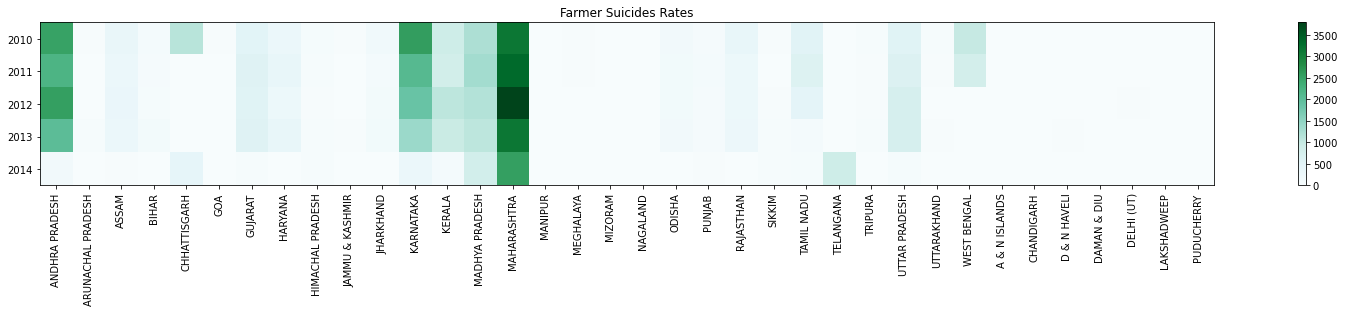

In [20]:
mat8 = np.matrix(suicides.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(30,3))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(suicides.columns[1:])))
ax.set_xticks(np.arange(len(suicides.values[:,0])))
ax.set_yticklabels(suicides.columns[1:])
ax.set_xticklabels(suicides.values[:,0],rotation='vertical')
plt.imshow(mat8, cmap='BuGn')
plt.colorbar()
plt.title('Farmer Suicides Rates')
plt.show()

#### 9. Lectura de datos de exportaciones de varios productos a lo largo de los años

In [21]:
exports = pd.read_csv('IndiaExport.csv',delimiter=',')
to_drop = []
for head in exports.columns[1:]:
    if 'Unn' in head:
        to_drop.append(head)
exports.drop(columns = to_drop,inplace=True)
exports = exports.drop(0)
exports.rename(columns = {'Unnamed: 0':'Product'},inplace = True)
for_plot = exports.copy()
exports = exports.melt(id_vars='Product')
exports.variable = exports.variable.astype(int)
exports.value = exports.value.astype(float)
exports.head()

,Product,variable,value
0,Buffalo Meat,2003,343817.08
1,Basmati Rice,2003,771475.37
2,Rice,2003,2640438.93
3,Guargum,2003,120561.27
4,Wheat,2003,4093080.52


#### Selección de datos relacionados solo con productos agrícolas

In [22]:
plot_exports=for_plot.copy()
plot_exports=plot_exports.reset_index(drop=True)
to_drop=[]
ct=0
for head in plot_exports.Product:
    if 'Meat' in head:
        to_drop.append(head)
        plot_exports.drop(ct,inplace=True)
    ct+=1
plot_exports.drop([9,15,23,26,29,32],inplace=True)
plot_exports = plot_exports.reset_index(drop=True)
plot_exports.Product[plot_exports.Product=='Cucumber and Gherkins( Prepd. & Presvd)'] = 'Cucumber and Gherkins'
plot_exports.head()

,Product,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,Basmati Rice,771475.37,1162989.16,1166562.79,1045714.95,1183355.73,1556411.06,2016775,2370658.39,3178174.43,3459898.93,3757271.42,3702260.07
1,Rice,2640438.93,3615109.55,2921601.91,3702191.99,5285916.33,931879.8,139540.76,100685.78,3997719.57,6687990.85,7133183.37,8274046.02
2,Guargum,120561.27,131299.98,186718.4,189304.36,211166.56,258567.56,218479.74,441607.7,707326.43,406311.81,601945.42,665177.71
3,Wheat,4093080.52,2009343.03,746173.23,46633.21,237.27,1120.52,47.3,394.47,740746.76,6514810.6,5562374.74,2924070.18
4,Groundnuts,176109.32,177154.08,190053.34,251428.65,269587.64,297890.37,340246.31,433753.23,832616.93,535637.36,509664.84,708386.26


#### Visualización de exportaciones de productos agrícolas

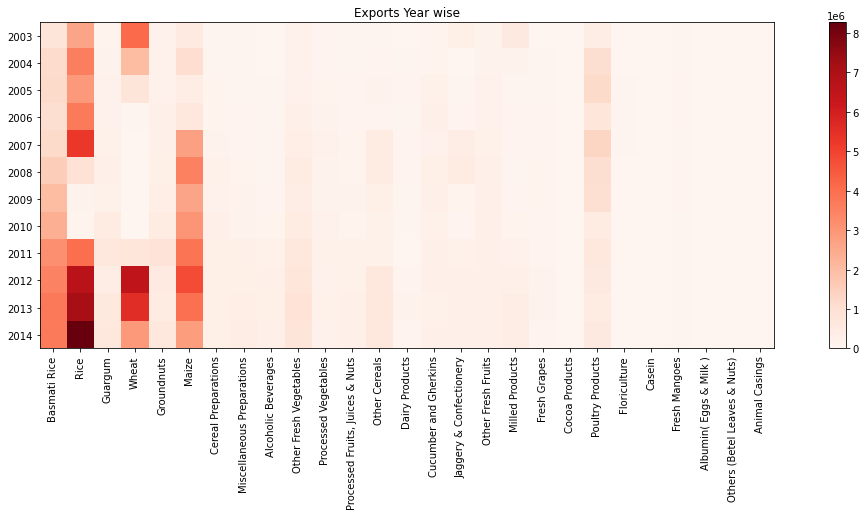

In [23]:
mat8 = np.matrix(plot_exports.values[:,1:],dtype='float').T
fig = plt.figure(num=5,figsize=(20,6))
ax = fig.add_subplot(1,1,1)
ax.set_yticks(np.arange(len(plot_exports.columns[1:])))
ax.set_xticks(np.arange(len(plot_exports.values[:,0])))
ax.set_yticklabels(plot_exports.columns[1:])
ax.set_xticklabels(plot_exports.values[:,0],rotation='vertical')
plt.imshow(mat8, cmap='Reds')
plt.colorbar()
plt.title('Exports Year wise')
plt.show()

#### Separar los datos del área de la tabla de datos principal

In [24]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area.head()

,State_Name,Crop_Year,Crop,Area
0,Andaman and Nicobar Islands,2000,Arecanut,4354.0
1,Andaman and Nicobar Islands,2000,Other Kharif pulses,670.0
2,Andaman and Nicobar Islands,2000,Rice,10881.0
3,Andaman and Nicobar Islands,2000,Banana,1707.0
4,Andaman and Nicobar Islands,2000,Cashewnut,800.0


#### Separar los datos de producción de la tabla de datos principal

In [25]:
production = pd.concat([crop_prod.iloc[:,0:5],crop_prod.iloc[:,6:7]],axis=1)
production = production.loc[production.loc[:,'Crop_Year'] >=2000,:]
# production.drop(columns={'Production'},inplace=True)
production = production.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
production.Crop[production.Crop == 'Paddy'] = 'Rice'
production.Crop[production.Crop == 'Moong(Green Gram)'] = 'Moong'
production.head()

,State_Name,Crop_Year,Crop,Production
0,Andaman and Nicobar Islands,2000,Arecanut,7200.0
1,Andaman and Nicobar Islands,2000,Other Kharif pulses,449.0
2,Andaman and Nicobar Islands,2000,Rice,32184.0
3,Andaman and Nicobar Islands,2000,Banana,12714.0
4,Andaman and Nicobar Islands,2000,Cashewnut,219.0


#### Conversión de nombres en la forma requerida tanto en la tabla de precios de área como de cultivo

In [28]:
area.Crop[area.Crop == 'Paddy'] = 'Rice'
area.Crop[area.Crop == 'Moong(Green Gram)'] = 'Moong'
list_area=sort(area.Crop.unique())
list_price=sort(crop_price.Commodities.unique())
for item in list_price:
    if 'Paddy' in item:
        crop_price.Commodities[crop_price.Commodities == item]='Rice'
for item in list_price:
    for item_area in list_area:
        if item.strip() in item_area or item_area.strip() in item:
            if item != item_area:
                crop_price.Commodities[crop_price.Commodities == item]=item_area
crop_price.Commodities[crop_price.Commodities == 'Cotton F-414/H-777 ']='Cotton(lint)'
crop_price.Commodities[crop_price.Commodities == 'Cotton H-4 750 ']='Cotton(lint)'
crop_price.Commodities[crop_price.Commodities == 'Paddy']='Rice'
crop_price = crop_price.groupby(['Commodities'],as_index=False,sort=False).sum()
# crop_price.head()

In [29]:
# Converting data to make it visualizable
area_price=area.iloc[:,1:]
area_price = area_price.groupby(['Crop_Year','Crop'],as_index=True,sort=False).sum()
area_price = area_price.iloc[:,:].unstack(level=0).reset_index()
area_price = area_price.fillna(0)
area_price.columns = area_price.columns.droplevel()
area_price.rename(columns={'':'Crop'},inplace=True)
area_price = area_price[area_price['Crop'].isin(crop_price.Commodities)].sort_values(by='Crop')
area_price.drop(columns={2000,2001,2003,2013,2014,2015},inplace=True)
area_price.columns = area_price.columns.astype(str)
area_price = area_price.reindex(sorted(area_price.columns), axis=1)
# temp = area_price.iloc[:,1:].reindex_axis(sorted(area_price.iloc[:,1:].columns), axis=1)
# reindex_axis deprecated .. replace with reindex
area_price.head()

Crop_Year,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012,Crop
17,2963889.15,2912104.08,2875328.46,3297134.83,2287957.63,3113224.0,3221594.0,4289565.0,3752892.0,3220916.0,Arhar/Tur
20,7736866.00,9326100.00,9676568.00,9499237.00,8339105.00,8774882.0,8972422.0,9607246.0,3752948.0,3231616.0,Bajra
76,664523.00,602355.57,614672.00,556516.00,604089.00,685198.0,565424.0,677806.0,325548.0,347179.0,Barley
22,7632933.00,8748496.00,8669295.00,9060875.00,6188044.00,9337428.0,9984615.0,10929723.0,11685196.0,9530632.0,Cotton(lint)
23,5892949.47,6636121.22,6819569.26,7625707.57,6348748.22,7818443.0,7274008.0,8862826.0,6335184.0,6544957.0,Gram


In [52]:
# Seleccionar los nombres de los cultivos que están presentes tanto en la tabla area_price como en la tabla crop_price
crop_price = crop_price[crop_price['Commodities'].isin(area_price.Crop)].sort_values(by='Commodities')
crop_price.head()

,Commodities,2002,2004,2005,2006,2007,2008,2009,2010,2011,2012
9,Arhar/Tur,1325.0,1390.0,1400.0,1410.0,1550.0,2000.0,2300.0,3000.0,3200,3850.0
3,Bajra,495.0,515.0,525.0,540.0,600.0,840.0,840.0,880.0,980,1175.0
6,Barley,505.0,540.0,550.0,565.0,650.0,680.0,750.0,780.0,980,980.0
13,Cotton(lint),3590.0,3720.0,3740.0,3760.0,3830.0,5500.0,5500.0,5500.0,6100,7500.0
7,Gram,1225.0,1425.0,1435.0,1445.0,1600.0,1730.0,1760.0,2100.0,2800,3000.0


#### Visualización del área de cultivo para cultivos por año

NameError: name 'Cycler' is not defined

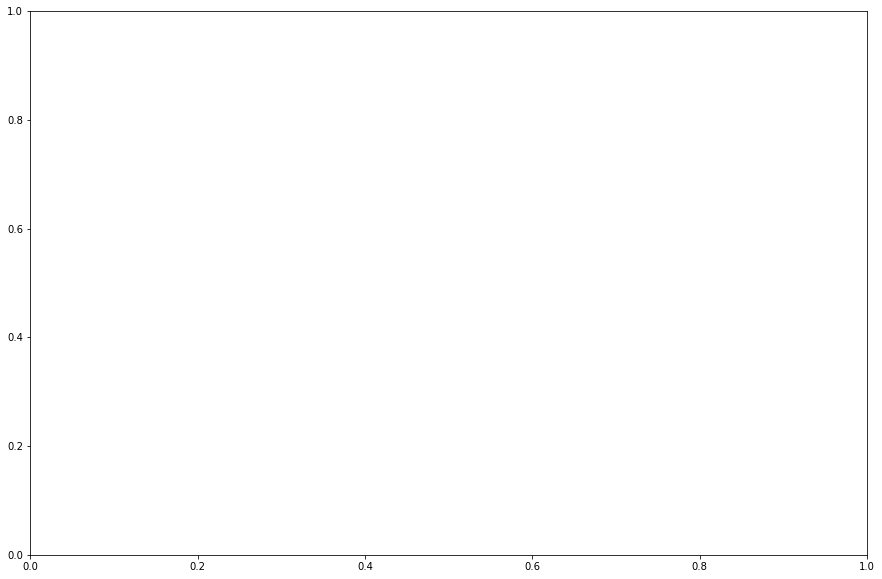

In [62]:
years= area_price.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,area_price.shape[0])])
for i in range(area_price.shape[0]):
    ax1.plot(area_price.columns[:area_price.shape[1]-1],area_price.iloc[i,:area_price.shape[1]-1])
mplot.legend(area_price.iloc[:,area_price.shape[1]-1],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Area under cultivation of major crops year wise')
mplot.show()

#### Visualizing the change in prices of crops year wise

In [ ]:
years= crop_price.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,crop_price.shape[0])])
for i in range(crop_price.shape[0]):
    ax1.plot(crop_price.columns[1:],crop_price.iloc[i,1:])
mplot.legend(crop_price.iloc[:,0],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Prices of major crops year wise')
mplot.show()

#### Converting production data to compare it from price data

In [ ]:
production_year=production.iloc[:,1:]
production_year = production_year.groupby(['Crop_Year','Crop'],as_index=True,sort=False).sum()
production_year = production_year.iloc[:,:].unstack(level=0).reset_index()
production_year = production_year.fillna(0)
production_year.columns = production_year.columns.droplevel()
production_year.rename(columns={'':'Crop'},inplace=True)
production_year = production_year[production_year['Crop'].isin(crop_price.Commodities)].sort_values(by='Crop')
production_year.drop(columns={2000,2001,2003,2013,2014,2015},inplace=True)
production_year.columns = production_year.columns.astype(str)
production_year = production_year.reindex_axis(sorted(production_year.columns), axis=1)
production_year.head()

#### Visualizing the production of crops year wise

In [ ]:
fig = mplot.figure(figsize=(15,10))
t = ("Sugarcane,Rice and Wheat have 1/10th of actual values to make data be relative and observable")
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,production_year.shape[0])])
for i in range(production_year.shape[0]):
    if  production_year.iloc[i,1] < 50000000:
        ax1.plot(production_year.columns[:production_year.shape[1]-1],production_year.iloc[i,:production_year.shape[1]-1])
    else:
        ax1.plot(production_year.columns[:production_year.shape[1]-1],production_year.iloc[i,:production_year.shape[1]-1]/10,linestyle='--')
mplot.legend(production_year.iloc[:,production_year.shape[1]-1],bbox_to_anchor=(1.02,1), borderaxespad=0)
plt.text(0,3.5*10000000, t, ha='left',va='top', rotation=0, wrap=True)
mplot.title('Amount of production of major crops year wise')
mplot.show()

### Finding earnings per per unit area for crop
earning = price * production / area

In [ ]:
ratio_prod_area = production_year.iloc[:,:area_price.shape[1]-1].reset_index(drop=True)/area_price.iloc[:,:area_price.shape[1]-1].reset_index(drop=True)
ratio_prod_area.index = area_price.index
ratio_prod_area=pd.concat([area_price.iloc[:,area_price.shape[1]-1],ratio_prod_area],axis=1)
# ratio_prod_area.head()
ratio_prod_area_earn = ratio_prod_area.iloc[:,1:].reset_index(drop=True)*crop_price.iloc[:,1:].reset_index(drop=True)
ratio_prod_area_earn.index = area_price.index
ratio_prod_area_earn=pd.concat([area_price.iloc[:,area_price.shape[1]-1],ratio_prod_area_earn],axis=1)
ratio_prod_area_earn.head()

#### Visualising possible earnings on major crops per unit area year wise

In [ ]:
years= ratio_prod_area_earn.columns[1:]
fig = mplot.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
colormap = plt.cm.nipy_spectral
ax1.set_color_cycle([colormap(i) for i in np.linspace(0, 1,ratio_prod_area_earn.shape[0])])
for i in range(ratio_prod_area_earn.shape[0]):
    ax1.plot(ratio_prod_area_earn.columns[1:],ratio_prod_area_earn.iloc[i,1:])
mplot.legend(ratio_prod_area_earn.iloc[:,0],bbox_to_anchor=(1.02,1), borderaxespad=0)
mplot.title('Possible earnings on major crops per unit area year wise')
mplot.show()

#### Taking data to copare with rainfall

In [ ]:
prod_rain = crop_prod.copy()
prod_rain = prod_rain.loc[prod_rain.loc[:,'Crop_Year'] >=2000,:]
prod_rain = prod_rain.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
prod_rain.iloc[:,0]=prod_rain.iloc[:,0].str.upper()
prod_rain = prod_rain.drop(columns = {'Crop','Production'})
prod_rain = prod_rain.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
prod_rain.State_Name[prod_rain.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
prod_rain.State_Name[prod_rain.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
prod_rain.State_Name[prod_rain.State_Name == 'ODISHA'] = 'ORISSA'
prod_rain.State_Name[prod_rain.State_Name == 'TELANGANA '] = 'TELANGANA'
# prod_rain.head()

In [ ]:
temp_rain = pd.concat([rainfall.iloc[:,0:2],rainfall.iloc[:,rainfall.shape[1]-1]],axis=1)
prod_rain = prod_rain[prod_rain['State_Name'].isin(temp_rain.STATES)]
temp_rain = temp_rain[temp_rain['STATES'].isin(prod_rain.State_Name)]
temp_rain.head()

In [ ]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area_temp = area.drop(columns = 'Crop')
area_temp = area_temp.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
area_temp.iloc[:,0]=area_temp.iloc[:,0].str.upper()
area_temp.State_Name[area_temp.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
area_temp.State_Name[area_temp.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
area_temp.State_Name[area_temp.State_Name == 'ODISHA'] = 'ORISSA'
area_temp.State_Name[area_temp.State_Name == 'TELANGANA '] = 'TELANGANA'
# area_temp.shape,temp_rain.shape
area_temp = area_temp[area_temp['State_Name'].isin(temp_rain.STATES)]
temp_rain = temp_rain[temp_rain['STATES'].isin(area_temp.State_Name)]
area_temp.head()
# ratio_prod_rain = pd.concat([prod_rain.iloc[:,0:3],prod_rain.Area*temp_rain.ANNUAL],axis=1)
# ratio_prod_rain

In [ ]:
area_rainfall = pd.merge(area_temp.rename(columns={"State_Name": "STATES", "Crop_Year": "YEAR"}),temp_rain,how='inner')
area_rainfall.head()

In [ ]:
# area_rainfall.Area = area_rainfall.Production/(area_rainfall.Area*area_rainfall.ANNUAL)
# area_rainfall.head()

In [ ]:
suicides.head()
suicides.rename(columns={'State/UT':'STATES'},inplace = True)

In [ ]:
area_rainfall_plot = area_rainfall[area_rainfall['STATES'].isin(suicides.STATES)]
area_rainfall_plot.dropna()
suicides = suicides[suicides['STATES'].isin(area_rainfall_plot.STATES)]
area_rainfall_plot.shape

#### Taking ratio of area * rainfall vs Production
- If this value is high it shows that the farmers had losses 

In [ ]:
area_rainfall['Calc'] = (area_rainfall.Area*area_rainfall.ANNUAL)/area_rainfall.Production
# area_rainfall

In [ ]:
area_rainfall = pd.merge(area_temp.rename(columns={"State_Name": "STATES", "Crop_Year": "YEAR"}),temp_rain,how='inner')
area_rain_no0=area_rainfall.copy()
# area_rain_no0.iloc[:,2:] = fill_0(area_rain_n0.iloc[:,2:])
area_rain_no0.head()

#### Finding States that are affected by annual avg rainfall by area(i.e. Area vs Rainfall)
- This signifies which of the states are heavily dependent on rainfall for area under cultivation

In [ ]:
ct = 1
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:] 
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,0],tp.iloc[:,2])
    mplot.title(i)
    ct+=1
mplot.show()

#### Finding States that are affected by annual avg rainfall for Production(i.e. Production vs Rainfall)
- This signifies which states area affected by rainfall for production

In [ ]:
ct = 0
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:]
    ct+=1
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,1],tp.iloc[:,2])
    mplot.title(i)
mplot.show()

#### Finding States that are affected by annual avg rainfall by ratio of production and area(i.e. Production/Area vs Rainfall)
- This signifies in which states the ratio of products and area under cultivation is affected by Rainfall

In [ ]:
ct = 0
fig = mplot.figure(figsize=(20,22))
for i in area_rain_no0.STATES.unique():
    tp= area_rain_no0[area_rain_no0.STATES==i]
    tp=tp.iloc[:,2:]
    ct+=1
    mplot.subplot(6,5,ct)
    mplot.scatter(tp.iloc[:,1]/tp.iloc[:,0],tp.iloc[:,2])
    mplot.title(i)
mplot.show()

## Converting all data to merge into one table and then saving it in a csv file

In [ ]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['Crop_Year','Crop'],as_index=False,sort=False).sum()
# area_temp = area.drop(columns = 'Crop')
# area_temp = area_temp.groupby(['State_Name','Crop_Year'],as_index=False,sort=False).sum()
area_temp=area.copy()
# area_temp.shape,temp_rain.shape
# area_temp.head()

In [ ]:
area_heat =pd.merge(area_temp.rename(columns={"Crop_Year": "YEAR"}),temperature.iloc[:,0:2],how='inner',sort=False)
area_heat['Ratio'] = area_heat.Production/area_heat.Area
# area_heat.head()

In [ ]:
area = crop_prod.copy()
area = area.loc[area.loc[:,'Crop_Year'] >=2000,:]
# area.drop(columns={'Production'},inplace=True)
area = area.groupby(['State_Name','Crop_Year','Crop'],as_index=False,sort=False).sum()
area_temp=area.copy()
area_temp.iloc[:,0]=area_temp.iloc[:,0].str.upper()
area_temp.State_Name[area_temp.State_Name == 'ANDAMAN AND NICOBAR ISLANDS'] = 'ANDAMAN & NICOBAR ISLANDS'
area_temp.State_Name[area_temp.State_Name == 'JAMMU AND KASHMIR '] = 'JAMMU & KASHMIR'
area_temp.State_Name[area_temp.State_Name == 'ODISHA'] = 'ORISSA'
area_temp.State_Name[area_temp.State_Name == 'TELANGANA '] = 'TELANGANA'
area_temp.Crop[area_temp.Crop=='Paddy'] = 'Rice' 
area_temp.Crop[area_temp.Crop == 'Moong(Green Gram)'] = 'Moong'

In [ ]:
temp_crop_price = crop_price.melt(id_vars=['Commodities'])
temp_crop_price.variable=temp_crop_price.variable.astype(int)

In [ ]:
temp_cost = pd.concat([culti_cost.iloc[:,0:2],culti_cost.iloc[:,8:14]],axis=1)
years = temp_cost.columns[2:]
temp_cost.columns = list(temp_cost.columns[:2])+list([year[len(year)-7:len(year)-3] for year in years ])
temp_cost= temp_cost.melt(id_vars=['Crop','State/ UT Name'])
temp_cost.Crop[temp_cost.Crop=='Paddy'] = 'Rice'
temp_cost.Crop[temp_cost.Crop=='Arhar'] = 'Arhar/Tur'
temp_cost.Crop[temp_cost.Crop=='Cotton'] = 'Cotton(lint)'
temp_cost.Crop[temp_cost.Crop=='Rapeseed And Mustard'] = 'Rapeseed'
temp_cost.rename(columns={'State/ UT Name':'STATES'},inplace=True)
temp_cost.STATES = temp_cost.STATES.str.upper()
temp_cost.STATES[temp_cost.STATES=='ODISHA']='ORISSA'
temp_cost.variable = temp_cost.variable.astype(int)

In [ ]:
temp_cost1 = pd.concat([culti_cost.iloc[:,0:2],culti_cost.iloc[:,14:19]],axis=1)
years = temp_cost1.columns[2:]
temp_cost1.columns = list(temp_cost1.columns[:2])+list([year[len(year)-7:len(year)-3] for year in years ])
temp_cost1= temp_cost1.melt(id_vars=['Crop','State/ UT Name'])
temp_cost1.Crop[temp_cost1.Crop=='Paddy'] = 'Rice'
temp_cost1.Crop[temp_cost1.Crop=='Arhar'] = 'Arhar/Tur'
temp_cost1.Crop[temp_cost1.Crop=='Cotton'] = 'Cotton(lint)'
temp_cost1.Crop[temp_cost1.Crop=='Rapeseed And Mustard'] = 'Rapeseed'
temp_cost1.rename(columns={'State/ UT Name':'STATES'},inplace=True)
temp_cost1.STATES = temp_cost.STATES.str.upper()
temp_cost1.STATES[temp_cost1.STATES=='ODISHA']='ORISSA'
temp_cost1.variable = temp_cost1.variable.astype(int)

In [ ]:
temp_sui = suicides.copy()
temp_sui = temp_sui.melt(id_vars='STATES')
temp_sui.variable=temp_sui.variable.astype(int)

### Meging all data converted above

In [ ]:
merged_all=pd.merge(area_temp.rename(columns={'State_Name':'STATES','Crop_Year':'YEAR' }),temp_rain.rename(columns={'ANNUAL':'Annual_Rain'}),how='left')
merged_all=pd.merge(merged_all,temperature.iloc[:,0:2].rename(columns={'ANNUAL':'Avg_Temperature'}),how='left')
merged_all=pd.merge(merged_all,temp_crop_price.rename(columns={'Commodities':'Crop','variable':'YEAR','value':'Price'}),how='left')
merged_all=pd.merge(merged_all,temp_cost.rename(columns={'variable':'YEAR','value':'Cost_per_Hectare'}),how='left')
merged_all=pd.merge(merged_all,temp_cost1.rename(columns={'variable':'YEAR','value':'Cost_per_quintal'}),how='left')
merged_all = pd.merge(merged_all,temp_sui.rename(columns={'variable':'YEAR','value':'Suicides'}),how='left')
merged_all = pd.merge(merged_all,exports.rename(columns = {'Product':'Crop','variable':'YEAR','value':'Export'}),how='left')
merged_all.head()

#### Visualising Relationship between different features

In [ ]:
scat_plot = pd.scatter_matrix(merged_all,alpha=0.5,figsize=(18,18))
mplot.show()

In [ ]:
merged_all = merged_all.fillna(0)
merged_all.shape

In [ ]:
merged_all.to_csv('data_set.csv',index=False)

In [ ]:
data = pd.read_csv('data_set.csv')
print(data.shape)
data.head()

In [ ]:
data_set = data[(data['YEAR'] >=2010)*(data['YEAR'] <=2014) ].fillna(0).groupby(['YEAR','Suicides']).agg('mean').reset_index()
# data_set.head()

### Finding correlation between different features

In [ ]:
vals = data_set.corr()
vals

### Visualization of correlation between features

In [ ]:
fig=mplot.figure(figsize=(8,6))
mplot.imshow(vals.values)
mplot.colorbar()
mplot.show()

#### Using linear regression to find the model for suicides

In [ ]:
model = LR()
X = data_set.drop(columns = ['Suicides','YEAR'],axis=1)
y = data_set['Suicides']
tou = 1
Xx = X.values[y>tou]
Yy = y.values[y>tou]
v1 = Xx.mean(axis = 0)
v2 = Xx.std(axis = 0)
Xx = Xx - v1
Xx = Xx / v2
model.fit(Xx,Yy)
yd = model.predict(Xx)
model.score(Xx,Yy)

In [ ]:
mplot.plot(yd,Yy,'.')
mplot.title('Actual vs Predicted suicide rates')
mplot.show()

#### Using CART method to find the model for suicide rates

In [ ]:
model = scart(max_depth = 4)
model.fit(Xx,Yy)
model.score(Xx,Yy)

In [ ]:
Yd = model.predict(Xx)
fig = mplot.figure(figsize=(8,8))
mplot.plot(Yd,Yy,'.')
mplot.title('Actual vs Predicted suicide rates')
# mplot.savefig('Figures/suicide_pred_cart_model')
mplot.show()

In [ ]:
print(model.decision_path(Xx[0:1,:]))

In [ ]:
model.feature_importances_

In [ ]:
print(model.feature_importances_.argmax())
print(X.columns)

In [ ]:
import graphviz #install this library
from sklearn import tree

In [ ]:
dot_data = tree.export_graphviz(model, out_file=None,
                                feature_names=X.columns[:],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data,filename = 'dtree', format = 'png')

In [ ]:
# graph.render()

### Dtree model
Note: Commented as this was not working in other systems. If need to verify can uncomment it and check if it runs in the system. 

In [ ]:
# graph

In [ ]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()
dicts = {}
for crop in data_set['Crop'].unique():
    
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Production'].values
    if(X.shape[0] > 5):
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        dicts[crop] = [w]
#         print(w)

#### Finding the crops that have reduction in production over the years
- This will signify what crops are going be be rarely produced in future

In [ ]:
slope_data = pd.DataFrame(dicts).T.reset_index().rename(columns = {0:'W_slope'})
sns.catplot(x='index', y='W_slope', data = slope_data,  height=10, aspect=12/8.27);
plt.ylim(-5000,5000)
plt.xticks(rotation='vertical')
plt.plot([0,slope_data.shape[0]],[-1000,-1000])
plt.title('Bar for crops that has more reduction in production over the years')
# plt.savefig('Figures/Crops_reduction')
plt.show()

In [ ]:
slope_data[slope_data.W_slope<-1000]

In [ ]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()

#### Finding crops that have reduction in production but their price is increasing
- This signifies that these products demands are still there but there production quantity is reducing which means these crops might give better returns if taken up up by few farmers

In [ ]:
dicts = {}
dicts2 = {}
dicts3 = {}
maxw = 0
for crop in data_set['Crop'].unique():
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Production'].values
    Y2 = data_set[data_set['Crop'] == crop]['Price'].values
    X = X[Y2 > 0]
    Y = Y[Y2 > 0]
    Y2 = Y2[Y2 > 0]
    if(X.shape[0] > 5):    
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        linmodel.fit(X,Y2)
        w2 = linmodel.coef_[0]
        if(w > maxw):
            maxw = w
        if(w < 0 and w2 > 0):
            dicts[crop] = [w,w2]
        if(w < 10000 and w2 > 100): 
            dicts2[crop] = [w,w2]
        dicts3[crop] = [w,w2]

In [ ]:
slope_data = pd.DataFrame(dicts).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

#### Finding the crops which has lower increase in production but are increasing in price
- Gives inforamtion about what crops might be more prfitable to produce

In [ ]:
slope_data = pd.DataFrame(dicts2).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

In [ ]:
slope_data = pd.DataFrame(dicts3).T.reset_index().rename(columns = {0:'production var',1:'price var'})
slope_data

In [ ]:
data_set = data.fillna(0).groupby(['Crop','YEAR']).agg('mean').reset_index()

In [ ]:
dicts = {}
dicts2 = {}
dicts3 = {}
maxw = 0
for crop in data_set['Crop'].unique():
    
    X = data_set[data_set['Crop'] == crop]['YEAR'].values.reshape(-1,1)
    Y = data_set[data_set['Crop'] == crop]['Cost_per_Hectare'].values
    Y2 = data_set[data_set['Crop'] == crop]['Price'].values
    
    X = X[Y2 > 0]
    Y = Y[Y2 > 0]
    Y2 = Y2[Y2 > 0]
    
    if(X.shape[0] > 5):
        linmodel = LR()
        linmodel.fit(X,Y)
        w = linmodel.coef_[0]
        linmodel.fit(X,Y2)
        w2 = linmodel.coef_[0]
        
        if(w> 0):
            dicts3[crop] = [w,w2]
#         print(w)

#### Finding crops that have lower rate of increase in cost per hectare than price
- This gives us information of the products that might be more preffered due to ratio of returns being more over increase in cost per heactare

In [ ]:
slope_data = pd.DataFrame(dicts3).T.reset_index().rename(columns = {0:'cost_per_hec var',1:'price var'})
slope_data['grow_ratio'] = (slope_data['cost_per_hec var']**-1)*slope_data['price var']
slope_data.sort_values(by = 'grow_ratio', ascending = False)

In [ ]:
#For abhishek
merged_all.columns

In [ ]:
merged_all['invar'] = (merged_all['Production'])

In [ ]:
state_crop = (merged_all[['STATES','Crop','invar']])
state_crop = state_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
state_crop = state_crop.pivot(index='STATES',columns = 'Crop',values = 'invar')
#Use fill na as per your choice
state_crop = state_crop.fillna(0)
state_crop.head()

In [ ]:
dict1 = {}
for i,row in enumerate(state_crop.index):
#     print(i)
    dict1[row] = state_crop.columns[state_crop.iloc[i].argsort()[::-1][:13]]

In [ ]:
pd.DataFrame(dict1).T

currently growing high prodcution crops

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
model = NMF(n_components=2, init='random', random_state=0)

In [ ]:
X = state_crop.fillna(0).values

In [ ]:
W = model.fit_transform(X)

In [ ]:
H = model.components_

In [ ]:
state_crop[:] = (np.dot(W,H))

In [ ]:
state_crop.head()

In [ ]:
dict1 = {}
for i,row in enumerate(state_crop.index):
#     print(i)
    dict1[row] = state_crop.columns[state_crop.iloc[i].argsort()[::-1][:13]]

In [ ]:
pd.DataFrame(dict1).T

>This are recommended crops to grow in each state seperately based on the production trends. But as you will see coconut is not feasible in every state but since we are not considering soil data this is reasonable we can report if soil supports then these states can grow these crops which are likely to have high production per unit area.

#### Finding the cluster for crops using all the features

In [ ]:
for_cluster = merged_all[['Crop', 'Area', 'Production', 'Annual_Rain','Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal','Suicides']]
for_cluster = for_cluster.groupby(['Crop']).agg('mean').reset_index()
for_cluster = for_cluster.drop(28)
for_cluster.head()

In [ ]:
X = TSNE(n_components=2).fit_transform(for_cluster.iloc[:,1:])
k=5
kmeans = km(n_clusters=k, random_state=0).fit(X)
y = kmeans.labels_
list(set(y))
N= len(list(set(y)))
cmap = mplot.cm.jet
colors = cmap(np.linspace(0, 1, N))
fig = mplot.figure(figsize=(10,10))
for i in list(set(y)):
    mplot.scatter(X[y==i,0],X[y==i,1],c=colors[i],label=str('Class '+str(i)))
mplot.legend()
mplot.title('Clustering for crops using all the features')
# mplot.xlim(-15,)
# mplot.ylim(-20,)
mplot.show()

In [ ]:
#### Crops falling in same cluster
for i in range(k):
    print('Cluster ',i,list(set(for_cluster.Crop[y==i].values)),'\n')

#### Finding the clusters of states with year wise using all features

In [ ]:
# print(merged_all.columns)
from sklearn.cluster import AgglomerativeClustering

In [ ]:
for_cluster = merged_all[['STATES','YEAR', 'Area', 'Production', 'Annual_Rain','Avg_Temperature', 'Price', 'Cost_per_Hectare', 'Cost_per_quintal','Suicides']]
for_cluster = for_cluster.groupby(['STATES','YEAR']).agg('mean').reset_index()
for_cluster.head()
X = TSNE(n_components=2).fit_transform(for_cluster.iloc[:,2:])
# k=4
# kmeans = km(n_clusters=k, random_state=0).fit(X)
# y = kmeans.labels_
clustering = AgglomerativeClustering(n_clusters=5).fit(X)
y=clustering.labels_
list(set(y))
N= len(list(set(y)))
cmap = mplot.cm.jet
colors = cmap(np.linspace(0, 1, N))
fig = mplot.figure(figsize=(10,10))
for i in list(set(y)):
    mplot.scatter(X[y==i,0],X[y==i,1],c=colors[i],label=str('Class '+str(i)))
mplot.legend()
mplot.title('Clustering of states with year using all features')
mplot.show()

In [ ]:
#### Crops falling in same cluster
for i in range(k):
    print('Cluster ',i,list(set(for_cluster.STATES[y==i].values)),'\n')

#### Finding the crops with maximum production in each state

In [ ]:
max_crop = merged_all[['STATES','YEAR','Crop','Production']]
max_crop = max_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
max_crop.drop(columns='YEAR',inplace=True)
idx = max_crop.groupby(['STATES'])['Production'].transform(max) == max_crop['Production']
max_crop[idx]

#### Maximum produced crops in states year wise

In [ ]:
max_crop_yearly = merged_all.groupby('STATES').agg('mean').reset_index()
max_crop_yearly = max_crop_yearly[['STATES']]
for i in merged_all.YEAR.unique():
    max_crop = merged_all[['STATES','YEAR','Crop','Production']]
    max_crop = max_crop[max_crop.YEAR==i]
    max_crop = max_crop.groupby(['STATES','Crop']).agg('sum').reset_index()
    max_crop.drop(columns='YEAR',inplace=True)
    idx = max_crop.groupby(['STATES'])['Production'].transform(max) == max_crop['Production']
    max_crop_yearly = pd.merge(max_crop_yearly,max_crop[idx][['STATES','Crop']].reset_index(),how='left')
    max_crop_yearly.drop(columns= {'index'},inplace=True)
    max_crop_yearly.rename(columns={'Crop':i},inplace=True)
max_crop_yearly.drop(columns={2015},inplace=True) # Since data for only Assam and Orrisa are available
max_crop_yearly